In [ ]:
## Importing necessary libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt

%matplotlib inline

# **Corner detector function**

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']
print(X0.shape,Y0.shape)

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 175MB/s]
Archive:  /content/part1_images.zip
replace /content/part1_images/hotel.seq41.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y
  
  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)
    
  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

# Keypoint Selection

For the first frame, the second moment matrix to locate strong corners to use as keypoints. These points will be tracked throughout the sequence in the second part of the problem. Proper threshold so that edges and noisy patches are ignored. Local non-maxima suppression over a 5x5 window centered at each point. This should give several hundred good points to track.

Raw points


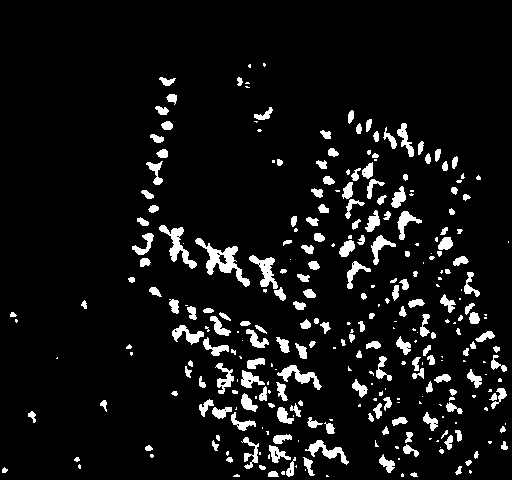

After NMS


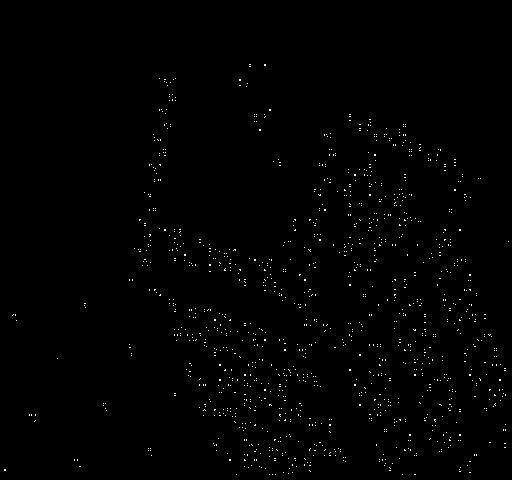

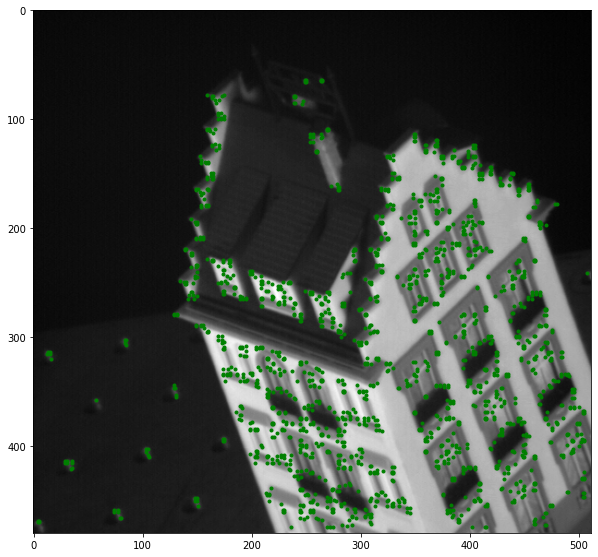

In [ ]:
from pprint import pprint
def getKeypoints(img,tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  # YOUR CODE HERE
  
  grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
  #to compute harris operator, H matrix is required
  sobelx = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=5)

  sobely = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=5)
  
  X=[]
  Y=[]
  
  f = np.zeros((grey.shape))
  count =0
  for i in range(grey.shape[0]-5):
    for j in range(grey.shape[1]-5):
      temp_A = 0
      temp_B = 0
      temp_C = 0
      #5x5 window
      for k in range(5):
        for l in range(5):
          temp_A += sobelx[i+k][j+l]**2
          temp_B += sobelx[i+k][j+l]*sobely[i+k][j+l]
          temp_C += sobely[i+k][j+l]**2
      #second moment matrix
      H = np.array([[temp_A,temp_B],
                    [temp_B,temp_C]])   
      if(np.linalg.det(H) / (np.trace(H)*(10**7)) > tau):
          #harris opertor(an approximation to minimum eigen value)
          f[i+2][j+2] = np.linalg.det(H) / (np.trace(H))
          X.append(i+2)
          Y.append(j+2)
          count+=1
  print("Raw points")
  cv2_imshow(f)

  #nms 5x5
  f_nms = np.zeros((f.shape))
  
  for i in range(0,f.shape[0] - 5,5):
      for j in range(0,f.shape[1] -5,5):
        
        temp = np.unravel_index(np.argmax(f[i:i+5,j:j+5],axis = None),(5,5))
        f_nms[i+temp[0]][j+temp[1]] = f[i+temp[0]][j+temp[1]]
  print("After NMS")
  cv2_imshow(f_nms)
  points = np.where(f_nms[:,:]>0)
  return points

# compute keypoints in the first sequence
tau = 0.2
key_pts = getKeypoints(im[0],tau)

# add plots for the write-up
key_img = plt.imread('/content/part1_images/hotel.seq0.png')
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(key_pts[1],key_pts[0], marker='.', color="g")
plt.imshow(key_img,cmap = 'gray')


# Feature Tracking

Kanade-Lucas-Tomasi tracking procedure


keypoints of image1 and tracked points in image 2


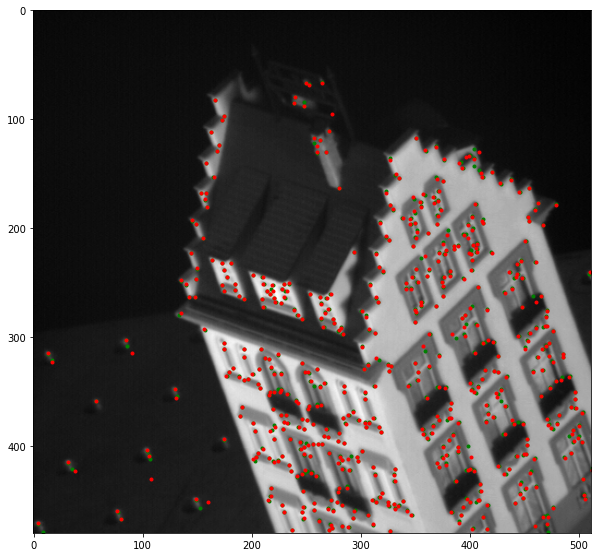

20 random points tracking


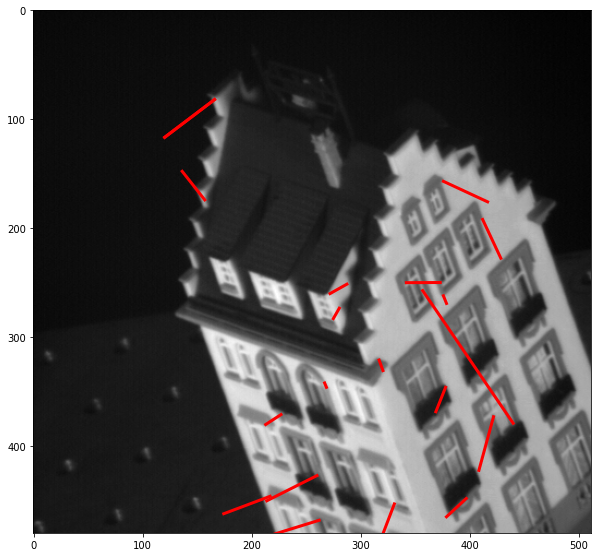

tarcking for all points


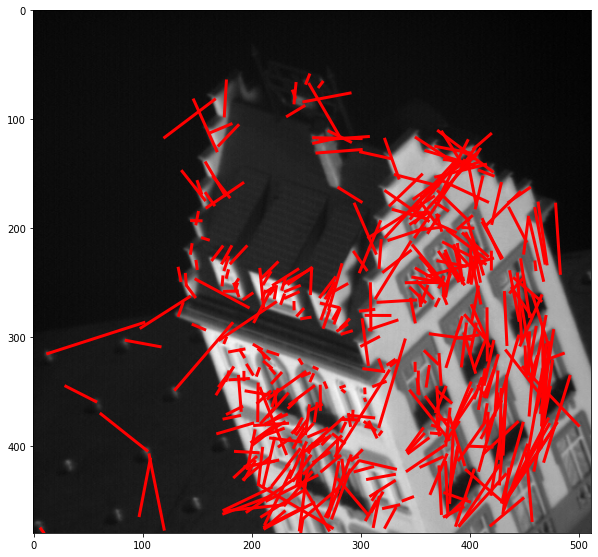

points that movedd out of frame


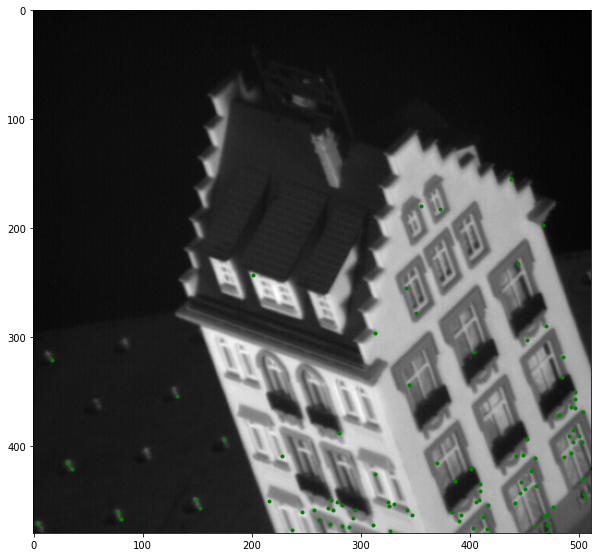

In [ ]:
from numpy.ma.extras import vstack
from pprint import pprint
import random
def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  
  # YOUR CODE HERE
  trkX = []
  trkY = []
  grey1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
  grey2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
   
  for i in range(len(x)):
    X=0
    Y=0
    
    for iter in range(75):  
      #15x15 window
      
      sub1 = cv2.getRectSubPix(grey1,(ws,ws),(x[i]+X,y[i]+Y))
      sobelx = cv2.Sobel(sub1,cv2.CV_64F,1,0,ksize=5)
      sub2 = cv2.getRectSubPix(grey2,(ws,ws),(x[i]+X,y[i]+Y))
      sobely = cv2.Sobel(sub2,cv2.CV_64F,0,1,ksize=5)
      Ixx = np.sum(sobelx**2) 
      Ixy = np.sum(np.dot(sobelx,sobely))
      Iyy= np.sum(sobely**2) 
      rhs_x = np.sum(np.dot(sobelx,sub2-sub1))
      rhs_y = np.sum(np.dot(sobely,sub2-sub1))

      #second moment matrix
      H = np.array([[Ixx,Ixy],
                    [Ixy,Iyy]])
     
      rhs = np.array([[rhs_x],[rhs_y]])
     
      u,v = -np.dot(np.linalg.pinv(H), rhs)
    
      X += u[0]
      Y += v[0]
    
    trkX.append(x[i]+X)
    trkY.append(y[i]+Y)
    
  return trkX,trkY
   
    

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 15
key_pts=np.concatenate((X0,Y0),axis=1)
tracked_ptsX,tracked_ptsY= trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

# plot your results
# YOUR CODE HERE
fr_img = plt.imread('/content/part1_images/hotel.seq0.png')
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(tracked_ptsX[:,0],tracked_ptsY[:,0], color="g",marker ='.')
plt.scatter(tracked_ptsX[:,1],tracked_ptsY[:,1], color="r",marker ='.')
print("keypoints of image1 and tracked points in image 2")
plt.imshow(fr_img,cmap = 'gray')
plt.show()


fr_img1 = plt.imread('/content/part1_images/hotel.seq0.png')
plt.rcParams["figure.figsize"] = (10,10)
count = 0
for i in range (555):
  plot = random.randint(0,554)
  x = ((tracked_ptsX[plot,0]-tracked_ptsX[plot,50])**2 + (tracked_ptsY[plot,0]-tracked_ptsY[plot,50])**2)** 0.5 
  if x<150 and 0<tracked_ptsX[plot,50]<480 and 0<tracked_ptsX[plot,0]<480 and 0<tracked_ptsY[plot,0]<512 and 0<tracked_ptsY[plot,50]<512:
    plt.plot((tracked_ptsX[plot,0],tracked_ptsX[plot,50]),(tracked_ptsY[plot,0],tracked_ptsY[plot,50]), color="r",linewidth = 3)
    count+=1
  if count == 20:
    break;
print("20 random points tracking")    
plt.imshow(fr_img1,cmap = 'gray')
plt.show()

fr_img_all = plt.imread('/content/part1_images/hotel.seq0.png')
plt.rcParams["figure.figsize"] = (10,10)

#allpoints
for plot in range (555):
  
  x = ((tracked_ptsX[plot,0]-tracked_ptsX[plot,50])**2 + (tracked_ptsY[plot,0]-tracked_ptsY[plot,50])**2)** 0.5 
  if x<100 and 0<tracked_ptsX[plot,50]<512 and 0<tracked_ptsX[plot,0]<512and 0<tracked_ptsY[plot,0]<480 and 0<tracked_ptsY[plot,50]<480:
    plt.plot((tracked_ptsX[plot,0],tracked_ptsX[plot,50]),(tracked_ptsY[plot,0],tracked_ptsY[plot,50]), color="r",linewidth = 3)
print("tarcking for all points")    
plt.imshow(fr_img_all,cmap = 'gray')
plt.show()

fr_img2 = plt.imread('/content/part1_images/hotel.seq0.png')
plt.rcParams["figure.figsize"] = (10,10)
for frame in range(50,51):
  for plot in range(555):
    
    if tracked_ptsX[plot,50] >512 or tracked_ptsX[plot,50] <0 or tracked_ptsY[plot,50]>480 or tracked_ptsY[plot,50]<0:
      plt.scatter(tracked_ptsX[plot,0],tracked_ptsY[plot,0], color="g",marker=".")
print("points that movedd out of frame")
plt.imshow(fr_img2,cmap = 'gray')
plt.show()

# Affine Sfm
Retrieve Shape and Motion using the keypoints from above

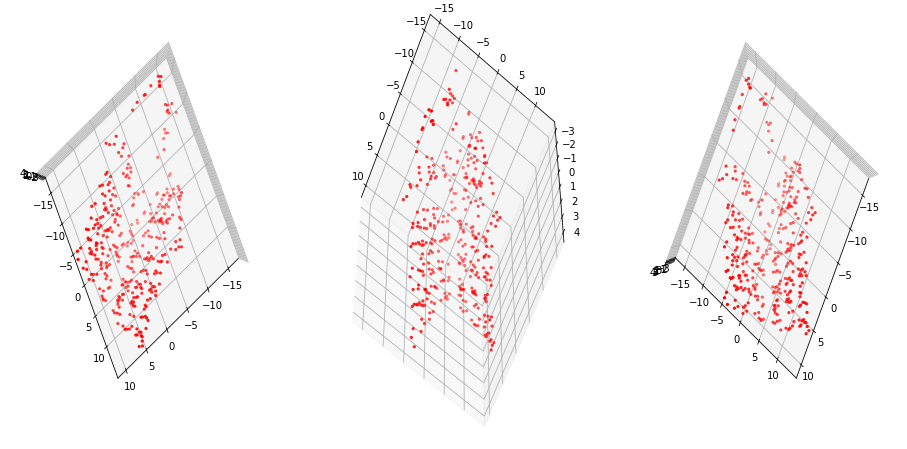

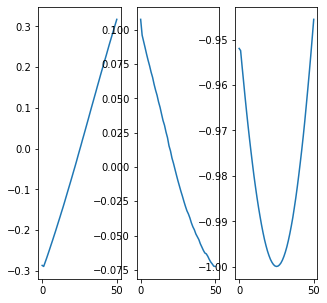

In [ ]:
from numpy.core.fromnumeric import reshape
import scipy.linalg 
from mpl_toolkits.mplot3d import Axes3D
track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
# YOUR CODE HERE
track_x = track_x.T
track_y = track_y.T
nan_index = np.argwhere(np.isnan(track_x))

for i in range(51):
  
    x = track_x[i] 
    y = track_y[i]
    x = np.delete(x,nan_index)
    y = np.delete(y,nan_index)
  
    if i == 0:
      track_x_cln = x
      track_y_cln = y
    else:
      track_x_cln = np.vstack((track_x_cln,x))
      track_y_cln = np.vstack((track_y_cln,y))

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE
   
  for i in range(51):
    x_cen = x[i]-np.mean(x[i])
    y_cen = y[i]-np.mean(y[i])
    
    if i == 0:
      D = np.vstack((x_cen,y_cen))
    else:
      D = np.vstack((D,x_cen,y_cen))
  U,W,VT = np.linalg.svd(D)
  W = np.diag(W)
  U3 = U[:,0:3]
  W3 = W[0:3,0:3]
  VT3 = VT[0:3,:]
  # Initial A and X
  M = np.dot(U3,np.sqrt(W3))
  S = np.dot(np.sqrt(W3),VT3)
  for i in range(0,102,2):
    temp = np.array([M[i][0]*M[i+1][0], M[i][1]*M[i+1][0],M[i][2]*M[i+1][0], M[i][0]*M[i+1][1],M[i][1]*M[i+1][1],M[i][2]*M[i+1][1],M[i][0]*M[i+1][2],M[i][1]*M[i+1][2],M[i][2]*M[i+1][2]])
    if i == 0:
      LS = temp
    else:
      LS = np.vstack((LS,temp))
  _,_,LT = np.linalg.svd(LS)
  L = reshape(LT[-1,:],(3,3))
  C = scipy.linalg.lu(L)
  # updated A an X
  A = np.dot(M,C[1])
  X = np.dot(np.linalg.inv(C[1]),S)
  return A,X

A,X = affineSFM(track_x_cln,track_y_cln)
# plotting X
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter3D(X[0,:],X[1,:],X[2,:],marker = '.',color='r')
ax.view_init(90,60)
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter3D(X[0,:],X[1,:],X[2,:],marker = '.',color='r')
ax.view_init(120,30)
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter3D(X[0,:],X[1,:],X[2,:],marker = '.',color='r')
ax.view_init(90,30)
plt.show()

for i in range(0,102,2):
  Ak = np.cross(A[i,:],A[i+1,:])
  a = np.linalg.norm(Ak)
  temp = Ak/a
  if i == 0:
    Ak_norm = temp
  else:
    Ak_norm = np.vstack((Ak_norm,temp))
# plotting Normalized A
plt.rcParams["figure.figsize"] = (5,5)
plt.subplot(1,3,1)
plt.plot(Ak_norm[:,0])
plt.subplot(1,3,2)
plt.plot(Ak_norm[:,1])
plt.subplot(1,3,3)
plt.plot(Ak_norm[:,2])
plt.show()